Name: Yoeel Sameh Nageh Dawod

ID: 320220203

AID Section: 3

Arabic handwritin Classification

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

https://www.kaggle.com/competitions/arabic-letters-classification/data

In [10]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/competitions/arabic-letters-classification/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yoeldawod
Your Kaggle Key: ··········


100%|██████████| 197M/197M [00:01<00:00, 131MB/s]



Extracting archive ./arabic-letters-classification/arabic-letters-classification.zip to ./arabic-letters-classification


In [41]:
# Parameters
datasets_paths = [
    '/content/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train',
    '/content/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test',
    '/content/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset'
]
IMAGE_SIZE = (160, 160)

In [43]:
# Set seed for reproducibility
torch.manual_seed(43)

# Define transforms for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomRotation(10),  # Similar to RandomRotation in TensorFlow
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.9, 1.0)),  # Similar to RandomZoom
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

In [44]:
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [109]:
# Load datasets
train_dataset = datasets.ImageFolder(datasets_paths[0], transform=train_transform)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [110]:
class_names = train_dataset.dataset.classes

train_loader.batch_size, len(train_loader), val_loader.batch_size, len(val_loader)

(512, 67, 512, 17)

(-0.5, 159.5, 159.5, -0.5)

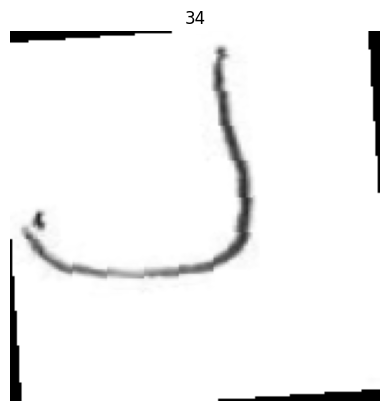

In [111]:
images, labels = next(iter(train_loader))

image=images[0]
label=labels[0]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [117]:
class Model(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.model = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=1024, out_features=output_shape)
        )

  def forward(self, x):
      return self.model(x)

model = Model(input_shape=1,#input_shape = the number of values of a pixel, here is one because the pictures are gray scale
                  output_shape=len(class_names)).to(device)
model

Model(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6400, out_featur

In [118]:
# Define optimizer and learning rate schedule
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
loss_fn = nn.CrossEntropyLoss()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [119]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0

  for batch, (x,y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    model.train()
    y_pred = model(x)

    loss = loss_fn(y_pred, y)#loss of this batch of images (x)
    train_loss += loss#train loss per epoch

    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
  return train_loss, train_acc

In [120]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x, y in data_loader:
      x, y = x.to(device), y.to(device)
      test_pred = model(x)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  print(f"\nTest loss: {test_loss:.5f}| Test acc: {test_acc:.2f}%\n")
  return test_loss, test_acc

In [121]:
from tqdm.auto import tqdm
torch.manual_seed(42)

epochs = 10

train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  epoch_train_loss, epoch_train_acc = train_step(model=model,
                                                data_loader=train_loader,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer,
                                                accuracy_fn=accuracy_fn)
  train_loss_history.append(epoch_train_loss)
  train_acc_history.append(epoch_train_acc)

  scheduler.step()

  epoch_val_loss, epoch_val_acc = test_step(model=model,
                                                data_loader=val_loader,
                                                loss_fn=loss_fn,
                                                accuracy_fn=accuracy_fn)

  val_loss_history.append(epoch_val_loss)
  val_acc_history.append(epoch_val_acc)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------

Train loss: 4.05930 | Train acc: 3.54%

Test loss: 3.57564| Test acc: 11.96%

Epoch: 1
---------

Train loss: 2.68572 | Train acc: 27.80%

Test loss: 1.84059| Test acc: 47.29%

Epoch: 2
---------

Train loss: 1.53931 | Train acc: 53.85%

Test loss: 1.27531| Test acc: 61.31%

Epoch: 3
---------

Train loss: 1.13672 | Train acc: 64.62%

Test loss: 0.98217| Test acc: 69.72%

Epoch: 4
---------

Train loss: 0.91825 | Train acc: 71.26%

Test loss: 0.88303| Test acc: 72.61%

Epoch: 5
---------

Train loss: 0.75382 | Train acc: 76.01%

Test loss: 0.76914| Test acc: 75.93%

Epoch: 6
---------

Train loss: 0.64830 | Train acc: 79.19%

Test loss: 0.71557| Test acc: 78.29%

Epoch: 7
---------

Train loss: 0.57266 | Train acc: 81.44%

Test loss: 0.67287| Test acc: 79.17%

Epoch: 8
---------

Train loss: 0.50431 | Train acc: 83.45%

Test loss: 0.61599| Test acc: 80.99%

Epoch: 9
---------

Train loss: 0.44239 | Train acc: 85.33%

Test loss: 0.60002| Test acc: 82.21%



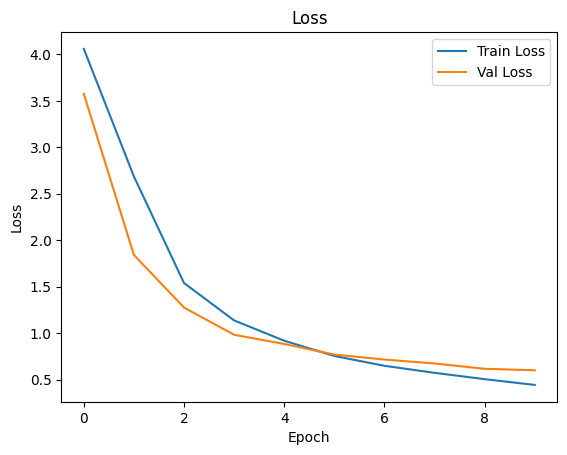

In [126]:
# Plot loss

plt.plot([epoch_loss.cpu().item() for epoch_loss in train_loss_history], label='Train Loss')
plt.plot([epoch_loss.cpu().item() for epoch_loss in val_loss_history], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

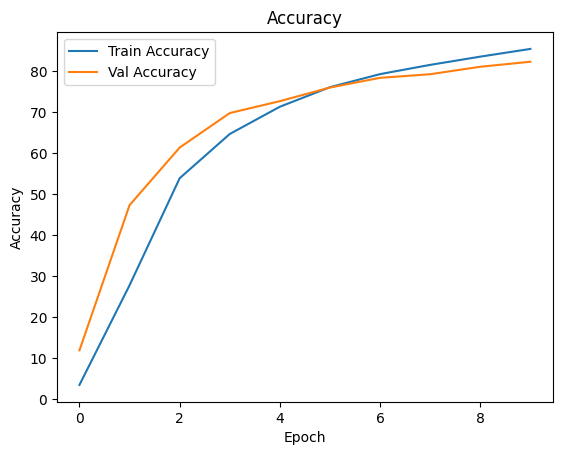

In [127]:
# Plot accuracy
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()